In [ ]:
import sys
!{sys.executable} -m pip install catboost

In [ ]:
import sys
!{sys.executable} -m pip install pandas-datareader

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
import plotly.express as px
import matplotlib.ticker as mtick
from scipy.stats import chi2_contingency
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

# Package que j'ai utiliser pour le VIX
import pandas_datareader.data as web
import datetime as dt

In [ ]:
df = pd.read_pickle("/Users/arthurdestribats/Downloads/data_propre.pkl")

In [ ]:
pd.options.display.max_columns = None
df.head()

In [ ]:
df.info()

In [ ]:
df["ApprovalDate"]= pd.to_datetime(df["ApprovalDate"], errors='coerce')
df = df.set_index("ApprovalDate")

In [ ]:
df.index.min()

In [ ]:
df.index.max()

In [ ]:
df.columns

- Période des données : On a des contrats qui vont d'octobre 1990 à juillet 2025
- La colonne programme ne sert à rien ici sachant que les prêts dans cette table concernent toujours le même programme
- Les noms des entreprises ne vont pas servir non plus dans la modélisation (trop de noms à encoder et dans tout les cas trop de granularité), on doit aussi enlever l'adresse exacte, la ville (car on a le code postal)
- LocationID (SBA's unique lender ID code) ne sert à rien ici sachant qu'on a deja des variables liées
- BankStreet, BankCity, BankFDICNumber, Bankzip sont également à enlever (par contre on garde le nom de la banque mais à voir pour l'encodage car 4000 banques diff)
- NAICSDescription (variable textuelle donc à enlever ou traitement de texte à faire ?) en plus redondant avec NAICcode
- CongressionalDistrict à enlever car on a deja le 'state' et le "county" du projet
- Le reste à garder

In [ ]:
df = df.drop_duplicates()

In [ ]:
df = df.drop(columns={'Program',
                      'BorrName',
                      'BorrStreet',
                      'BorrCity',
                      'LocationID',
                      'BankFDICNumber',
                      'BankZip',
                      'BankStreet',
                      'BankCity',
                      'NAICSDescription',
                      'CongressionalDistrict'
})

In [ ]:
print(df.shape)
df.columns

In [ ]:
df.info()

In [ ]:
# Mise au format date
df["FirstDisbursementDate"] = pd.to_datetime(df["FirstDisbursementDate"])

### Traitement des valeurs manquantes

#### A) Variables numériques

In [ ]:
# Pas de valeurs manquantes pour les variables numériques
col_numericals = ["GrossApproval", "SBAGuaranteedApproval", "TerminMonths", "JobsSupported"]
df[col_numericals].isna().sum()

#### B) Variables restantes

In [ ]:
col_restants = [col for col in df.columns if col not in col_numericals]
df[col_restants].isna().sum()

In [ ]:
# On voit que lorsque Bankstate est manquant on a MISSINGMAINBANKID comme nom de banque (inconnu)
df.loc[df["BankState"].isna()]

# On va donc imputer ces valeurs dans une catégorie "unknown"
df["BankName"] = np.where(df["BankName"]=="MISSINGMAINBANKID", "unknown", df["BankName"])
df["BankState"] = np.where(df["BankState"].isna(), "unknown", df["BankState"])
print(f'Nombre de lignes imputées {df[df["BankState"] == "unknown"].shape[0]}')

In [ ]:
# Les lignes ou FirstDisbursementDate est manquant les autres variables sont renseignées
df.loc[df['FirstDisbursementDate'].isna()]
# Sachant que le premier versement arrive après un certain temps de la date d'approbation on peut prendre la médiane (dans tout les cas ca n'aura pas un grand impact car peu de valeurs manquantes)
approval_dates = df.index.to_series()
delai_median = (df['FirstDisbursementDate'] - approval_dates).median()
valeurs_remplacement = approval_dates + delai_median
df['FirstDisbursementDate'] = df['FirstDisbursementDate'].fillna(valeurs_remplacement)

In [ ]:
# Pour la variable CollateralInd on a deux possibilités (oui/non), pour povuoir garder la variable on fait l'hypothèse que NaN = No
df["CollateralInd"]=df["CollateralInd"].fillna(0)
df["CollateralInd"] = np.where(df['CollateralInd'] == "Y", 1, 0)
df.CollateralInd.value_counts()

In [ ]:
# Seule possibilité est d'imputer par 'inconnu' pour NAICSCode
df["NAICSCode"] = df["NAICSCode"].fillna("inconnu")

### Analyse des variables numériques

In [ ]:
# Variables quanti
df_num = df[col_numericals]

In [ ]:
df_num.describe().round(3)

In [ ]:
#Visualisation graphique
for col in df_num.columns:
    plt.figure(figsize=(10, 5))

    if "Approval" in col:
        sns.histplot(data=df, x=col, kde=True, log_scale=True)
        plt.title(f"Distribution de {col}")
        
    elif "Termin" in col:
        sns.histplot(data=df, x=col, kde=False, bins=30, color='orange')
        plt.title(f"Distribution de {col} (Durée en mois)")
        plt.axvline(x=120, color='r', linestyle='--', label='10 ans') # 120 mois
        plt.axvline(x=240, color='g', linestyle='--', label='20 ans') # 240 mois
        plt.legend()
    else:
        sns.histplot(data=df, x=col, kde=True)
        plt.title(f"Distribution de {col}")

    plt.show()

- On voit qu'on a surtout à faire à des petites entreprises au vu de la distribution des emploi crées
- Les montants prêtés et garantis ont des distributions assez proches
- On a surtout à faire à des prêts de moins de 10 ans 

In [ ]:
# Visualisation en fonction de la cible
for col in df_num.columns:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    sns.boxplot(
        data=df, 
        x='LoanStatus', 
        y=col, 
        hue='LoanStatus',  
        legend=False,    
        ax=axes[0], 
        palette="Set2"
    )
    axes[0].set_title(f"Boxplot : {col} vs LoanStatus")
    

    if col in ['GrossApproval', 'JobsSupported']:
        axes[0].set_yscale('log')
    
    sns.kdeplot(
        data=df, 
        x=col, 
        hue='LoanStatus', 
        fill=True, 
        common_norm=False, 
        ax=axes[1], 
        palette="Set2"
    )
    axes[1].set_title(f"Densité : {col} selon LoanStatus")
    
    if col in ['GrossApproval', 'JobsSupported']:
        axes[1].set_xscale('log')

    plt.tight_layout()
    plt.show()

### Analayse de la variable cible dans le temps

In [ ]:
defaut_par_an = df.groupby('ApprovalFY')['LoanStatus'].mean()

plt.figure(figsize=(12, 6))
sns.lineplot(data=defaut_par_an, marker='o', color='crimson', linewidth=2.5)

plt.title("Évolution du Taux de Défaut par Année d'Approbation")
plt.ylabel("Taux de Défaut (1 = 100%)")
plt.xlabel("Année Fiscale (FY)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.axvspan(2007, 2009, color='gray', alpha=0.2, label='Crise 2008')
plt.legend()
plt.show()

- On voit graphiquement que de manière logique on a un pic des faillites en sur la période de la crise de 2008
- Il semble également y avoir un pic retardé de l'effet de la crise covid
- A voir si on garde la période de 2008 sachant que ca peut ajouter du bruit inutile dans le modèle (peutetre mettre une indicatrice des périodes de crise)
- On a une chute assez importante sur la dernière période (pas assez de données ?)

### Analyse des variables non numériques

In [ ]:
df["BusinessType"] = np.where(df["BusinessType"]== " ", "unknown", df["BusinessType"])
df.BusinessType.value_counts()
# On supprime les lignes ou on n'a pas de business type

In [ ]:
df = df.loc[df["BusinessType"].isin(["CORPORATION", "INDIVIDUAL", "PARTNERSHIP"])]
df.BusinessType.value_counts()

*Pour la variable NAICS code on peut trouver le secteur d'activité de l'entreprise à partir des deux premiers chiffres (permettra de différencier le risque selon le secteur)*

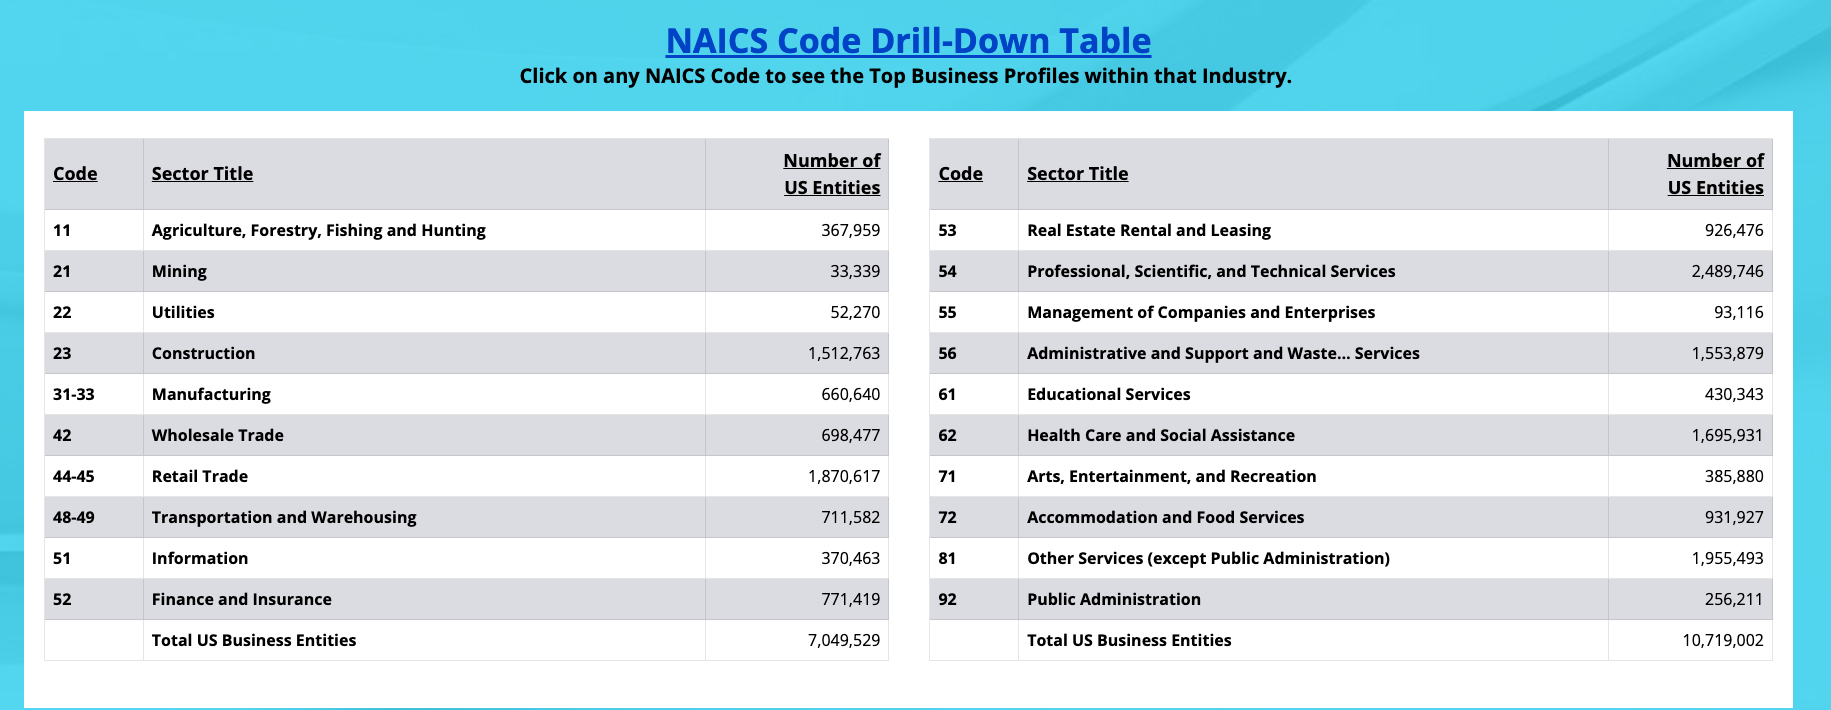

In [ ]:
# Dictionnaire pour relier le cdes premiers chifres du code NAIC selon le secteur (voir image dessus)
naics_map = {
    '11': 'Agriculture', '21': 'Mining', '22': 'Utilities', '23': 'Construction',
    '31': 'Manufacturing', '32': 'Manufacturing', '33': 'Manufacturing',
    '42': 'Wholesale', '44': 'Retail', '45': 'Retail',
    '48': 'Transport', '49': 'Transport', '51': 'Information',
    '52': 'Finance', '53': 'Real Estate', '54': 'Prof. Services',
    '55': 'Management', '56': 'Admin/Waste', '61': 'Education',
    '62': 'Health Care', '71': 'Arts/Entertainment', '72': 'Accommodation/Food',
    '81': 'Other Services', '92': 'Public Admin', "in": "Inconnu"
}

# On prend les deux premiers chiffres
df['Industry'] = df['NAICSCode'].astype(str).str[:2]

# On fait le mapping du dico
df['IndustryName'] = df['Industry'].map(naics_map).fillna(df['Industry'])

# On calcule le taux de défaut par industrie
industry_risk = df.groupby('IndustryName')['LoanStatus'].mean().sort_values(ascending=False)

In [ ]:
plt.figure(figsize=(14, 8))
sns.barplot(x=industry_risk.values, 
            y=industry_risk.index, 
            hue=industry_risk.index)
plt.title("Taux de Défaut par Secteur d'Activité (Industry)")
plt.xlabel("Taux de Défaut")
plt.axvline(x=df['LoanStatus'].mean(), color='r', linestyle='--', label='Moyenne Globale')
plt.legend()
plt.show()

On voit bien graphiquement que le risque dépend fortement du secteur d'activité avec des secteurs plus risquées que d'autres. Mais il faut faire aussi attention à la significativité de ces chiffres dans l'intérprétation.

In [ ]:
# ON voit qu'on a des secteurs qui sont tr!s faiblement représentés
df.IndustryName.value_counts()

In [ ]:
# Taux de défaut selon le businesstype (individuel, corpo, partnership)
business_risk = df.groupby('BusinessType')['LoanStatus'].mean().sort_values(ascending=False)
plt.figure(figsize=(14, 8))
sns.barplot(x=business_risk.values, 
            y=business_risk.index, 
            hue=business_risk.index)
plt.title("Taux de Défaut par business type")
plt.xlabel("Taux de Défaut")
plt.axvline(x=df['LoanStatus'].mean(), color='r', linestyle='--', label='Moyenne Globale')
plt.legend()
plt.show()

La encore on voit que la variable permet de bien différencier le risque, les entreprises individuels semblent bcp plus risquées que les autres types de boites

In [ ]:
collat_risk = df.groupby('CollateralInd')['LoanStatus'].mean().sort_values(ascending=False)

plt.figure(figsize=(10, 6)) # Format un peu plus compact pour des barres verticales
sns.barplot(x=collat_risk.index, 
            y=collat_risk.values, 
            hue=collat_risk.index, 
            legend=False, 
            palette="viridis")

plt.title("Taux de Défaut selon la présence ou non d'un collatéral", fontsize=16)
plt.xlabel("Indicateur de Collatéral", fontsize=12)
plt.ylabel("Taux de Défaut", fontsize=12)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.legend()
plt.show()

Les prêts sans collatéral sont logiquement plus risqués

#### Variables géographiques

In [ ]:
round(df["BorrState"].value_counts(), 5)
# On voit qu'il y des régions avec trop peu d'observations (à voir s'il ne faut pas les regrouper)

On a des états avec un nb d'obs très faible,  Je pense il faut regrouper lrsq le nb  d'obs de l'etat est inf à 100

In [ ]:
# ON fait le choix de regrouper à partir de VI dans une catégorie Other
freq = df['BorrState'].value_counts()
state_rares = freq[freq < 239].index
df.loc[df['BorrState'].isin(state_rares), 'BorrState'] = 'Other'

In [ ]:
state_risk = df.groupby('BorrState')['LoanStatus'].mean().sort_values(ascending=False)
plt.figure(figsize=(10, 15)) 
sns.barplot(x=state_risk.values, 
            y=state_risk.index, 
            hue=state_risk.index, 
            legend=False, 
            palette="coolwarm")

plt.title("Taux de Défaut par État (du plus risqué au moins risqué) après regroupement des petits", fontsize=16)
plt.xlabel("Taux de Défaut", fontsize=12)
plt.ylabel("État", fontsize=12)

mean_val = df['LoanStatus'].mean()
plt.axvline(x=mean_val, color='black', linestyle='--', label=f'Moyenne Globale: {mean_val:.2%}')
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.legend()
plt.tight_layout() 
plt.show()

In [ ]:
freq = df['BankState'].value_counts()
state_rares = freq[freq < 400].index
df.loc[df['BankState'].isin(state_rares), 'BankState'] = 'Other'

bank_state_risk = df.groupby('BankState')['LoanStatus'].mean().sort_values(ascending=False)

plt.figure(figsize=(10, 15)) 
sns.barplot(x=bank_state_risk.values, 
            y=bank_state_risk.index, 
            hue=bank_state_risk.index, 
            legend=False)

plt.title("Taux de Défaut par État de la banque (du plus risqué au moins risqué) après regroupement des petits", fontsize=16)
plt.xlabel("Taux de Défaut", fontsize=12)
plt.ylabel("État", fontsize=12)

mean_val = df['LoanStatus'].mean()
plt.axvline(x=mean_val, color='black', linestyle='--', label=f'Moyenne Globale: {mean_val:.2%}')
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.legend()
plt.tight_layout() 
plt.show()

La aussi on voit que selon l'état de la banque on a des taux de défaut très différent

In [ ]:
df.ProcessingMethod.value_counts()

In [ ]:
freq = df['ProcessingMethod'].value_counts()
rares = freq[freq < 1000].index
df.loc[df['ProcessingMethod'].isin(rares), 'ProcessingMethod'] = 'Other'
method_risk = df.groupby('ProcessingMethod')['LoanStatus'].mean().sort_values(ascending=False)

plt.figure(figsize=(10, 15)) 
sns.barplot(x=method_risk.values, 
            y=method_risk.index, 
            hue=method_risk.index, 
            legend=False)

plt.title("Taux de Défaut selon le process de prêt", fontsize=16)
plt.xlabel("Taux de Défaut", fontsize=12)
plt.ylabel("État", fontsize=12)

mean_val = df['LoanStatus'].mean()
plt.axvline(x=mean_val, color='black', linestyle='--', label=f'Moyenne Globale: {mean_val:.2%}')
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.legend()
plt.tight_layout() 
plt.show()

In [ ]:
# 1. Calcul du montant moyen par subprogram
mean_amount_by_subprogram = (
    df.groupby("ProcessingMethod")["GrossApproval"]
      .mean()
      .sort_values(ascending=True))

df["Mean_GrossApproval_by_Subprogram"] = df["Subprogram"].map(mean_amount_by_subprogram)

plt.figure(figsize=(12,6))
sns.barplot(
    x=mean_amount_by_subprogram.values,
    y=mean_amount_by_subprogram.index
)
plt.title("Montant moyen approuvé par type de Subprogram")
plt.xlabel("Montant moyen")
plt.ylabel("Subprogram")
plt.show()

In [ ]:
freq = df['Subprogram'].value_counts()
rares = freq[freq < 1000].index
df.loc[df['ProcessingMethod'].isin(rares), 'Subprogram'] = 'Other'
method_risk = df.groupby('ProcessingMethod')['LoanStatus'].mean().sort_values(ascending=False)

plt.figure(figsize=(10, 15)) 
sns.barplot(x=method_risk.values, 
            y=method_risk.index, 
            hue=method_risk.index, 
            legend=False)

plt.title("Taux de Défaut selon le process subprogram", fontsize=16)
plt.xlabel("Taux de Défaut", fontsize=12)
plt.ylabel("État", fontsize=12)

mean_val = df['LoanStatus'].mean()
plt.axvline(x=mean_val, color='black', linestyle='--', label=f'Moyenne Globale: {mean_val:.2%}')
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.legend()
plt.tight_layout() 
plt.show()

In [ ]:
# Taux de défaut selon RevolverStatus
pd.crosstab(df["RevolverStatus"], df["LoanStatus"], normalize="index")

In [ ]:
# Matrice de corrélation

In [ ]:
cols_corr = ['LoanStatus', 'GrossApproval', 'SBAGuaranteedApproval', 'TerminMonths', 'JobsSupported', 'RevolverStatus']
corr_matrix = df[cols_corr].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Matrice de Corrélation")
plt.show()

## Feature engineering

#### A. Outliers sur les variables quanti

 Au lieu de supprimer les outliers (qui sont porteurs d'information dans ce cadre surtout qu'on en a bcp au vu des boxplot qu'on a vu au dessus) on va plutot faire une transformation logarithmique permettant d'attenuer l'effet des outliers

In [ ]:
df['Log_GrossApproval'] = np.log1p(df['GrossApproval'])
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(df['GrossApproval'], ax=ax[0], bins=50).set_title("Avant Log")
sns.histplot(df['Log_GrossApproval'], ax=ax[1], bins=50).set_title("Après Log")
plt.show()

In [ ]:
df['Log_SBAGuaranteedApproval'] = np.log1p(df['SBAGuaranteedApproval'])
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(df['SBAGuaranteedApproval'], ax=ax[0], bins=50).set_title("Avant Log")
sns.histplot(df['Log_SBAGuaranteedApproval'], ax=ax[1], bins=50).set_title("Après Log")
plt.show()

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.boxplot(df['GrossApproval'], ax=ax[0]).set_title("Avant Log")
sns.boxplot(df['Log_GrossApproval'], ax=ax[1]).set_title("Après Log")
plt.show()

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.boxplot(df['SBAGuaranteedApproval'], ax=ax[0]).set_title("Avant Log")
sns.boxplot(df['Log_SBAGuaranteedApproval'], ax=ax[1]).set_title("Après Log")
plt.show()

In [ ]:
# Les contrats ou on a 0 temps restants
df = df[df["TerminMonths"]!=0]
df['TerminMonths_cut'] = pd.qcut(df["TerminMonths"], q=20, duplicates ='drop')

In [ ]:
volume = df['TerminMonths_cut'].value_counts(normalize=True).sort_index()
volume.index = volume.index.astype(str) 

risk = df.groupby('TerminMonths_cut', observed=False)['LoanStatus'].mean().sort_index()
risk.index = risk.index.astype(str)    

fig, ax1 = plt.subplots(figsize=(14, 7))


sns.barplot(x=volume.index, y=volume.values, ax=ax1, color='skyblue', alpha=0.6, label='Volume')
ax1.set_ylabel("Proportion (Volume)", fontsize=14, color='skyblue')
ax1.set_xlabel("Intervalle de Durée (Mois)", fontsize=14)
ax1.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

ax2 = ax1.twinx()

sns.lineplot(x=risk.index, y=risk.values, ax=ax2, color='red', marker='o', linewidth=3, label='Taux de Défaut')

ax2.set_ylabel("Taux de Défaut (Risque)", fontsize=14, color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

plt.title("Analyse Double : Volume vs Risque par Durée", fontsize=16)
ax1.tick_params(axis='x', rotation=45) # Rotation des étiquettes

plt.show()

In [ ]:
bins_cut = [0, 48, 68, 84, 120, 240, 600] # On est obligé de regrouper 60-68 avec la catégorie précédante car pas assez d'obs mais très diff 

df['TerminMonths_cut'] = pd.cut(df['TerminMonths'], bins=bins_cut)
df['TerminMonths_cut'].value_counts(normalize=True)

In [ ]:
df.groupby('TerminMonths_cut').agg({'LoanStatus' : "mean"})

In [ ]:
df["JobsSupported_cut"] = pd.qcut(df["JobsSupported"], q=20, duplicates='drop')

In [ ]:
df.groupby("JobsSupported_cut").agg({"LoanStatus" : "mean",
                                    "JobsSupported" : "count"})

In [ ]:
bins_jobs = [-0.001, 2, 3, 8, 10, 20, 99999]

df['JobsSupported_cut'] = pd.cut(df['JobsSupported'], bins=bins_jobs)
df['JobsSupported_cut'].value_counts(normalize=True)

In [ ]:
df

### C. Nouvelle partie feature engineering

J'ai pas bien compris ce que tu avais fait au dessus dans la partie feture engineering donc j'ai repris a 0 plus moins pour qu'on puisse comparer

#### a. On va crée des features temporelles

In [ ]:
# Age du pret 
df["Delay_Disbursement_Days"] = (df["FirstDisbursementDate"] - df.index).dt.days 

In [ ]:
# Durée d'approbation du pret (ca pourra nous permettre de voir l'influence des crises
df["ApprovalMonth"] = df.index.month # en mois
df["ApprovalQuarter"] = df.index.quarter # en trimestre 

In [ ]:
# Impact des crises
years = df.index.year
df["Crisis2008"] = ((years >= 2007) & (years <= 2009)).astype(int)
df["CovidPeriod"] = ((years >= 2020) & (years <= 2021)).astype(int)

In [ ]:
df[["Delay_Disbursement_Days","ApprovalMonth","ApprovalQuarter","Crisis2008","CovidPeriod"]].describe(include="all")

#### b. Mtn on crée des features sur les montants 

In [ ]:
# Plus le prêt est garanti, plus il est risqué côté SBA (risque comportemental).
df["GuaranteeRatio"] = df["SBAGuaranteedApproval"] / df["GrossApproval"]

In [ ]:
# Montant normalisé par secteur sur état
df["SectorPremium"] = df["GrossApproval"] / df.groupby("IndustryName")["GrossApproval"].transform("mean")

In [ ]:
# Montant sur capacité d'emploi
df["Approval_per_Job"] = df["GrossApproval"] / (df["JobsSupported"] + 1)

#### c. Features géographiques

In [ ]:
# Calcul du taux de défaut par État
state_risk = df.groupby("BorrState")["LoanStatus"].mean().sort_values(ascending=False)
plt.figure(figsize=(12, 10))
sns.barplot(x=state_risk.values,y=state_risk.index,palette="Reds")
plt.title("Taux de défaut moyen par État (SBA Loans)")
plt.xlabel("Taux de défaut")
plt.ylabel("État")
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.tight_layout()
plt.show()

In [ ]:
# En gros on guette si les banques locales pretent mieux (plus facilement à leurs clients)
df["IsLocalBank"] = (df["BorrState"] == df["BankState"]).astype(int)

In [ ]:
# Graphique pour voir que les banques qui sont non locales connaissent plus de défauts
local_risk = df.groupby("IsLocalBank")["LoanStatus"].mean()

plt.figure(figsize=(6,4))
sns.barplot(
    x=local_risk.index.map({0: "Banque NON locale", 1: "Banque locale"}),
    y=local_risk.values
)
plt.title("Taux de défaut selon localité de la banque")
plt.ylabel("Taux de défaut")
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.show()

plt.figure(figsize=(6,4))
sns.countplot(data=df, x="IsLocalBank")
plt.xticks([0,1], ["Banque non locale", "Banque locale"])
plt.title("Répartition des prêts selon la localité de la banque")
plt.xlabel("")
plt.ylabel("Nombre de prêts")
plt.show()

In [ ]:
# Askip grv important : on regarde par exemple si dans un lieu géographique x secteur d'activité c'est risqué 
df["Sector_State"] = df["IndustryName"] + "_" + df["BorrState"]

In [ ]:
sector_state_risk = (df.groupby("Sector_State")["LoanStatus"].mean().sort_values(ascending=False).head(20))
plt.figure(figsize=(10,8))
sns.barplot(x=sector_state_risk.values,y=sector_state_risk.index,palette="Reds")
plt.title("Top 20 couples Secteur × État les plus risqués")
plt.xlabel("Taux de défaut")
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.tight_layout()
plt.show()

#### d. Features historiques

(A utiliser plutot dans la base train)

In [ ]:
# On crée le taux de défaut moyen par banque
bank_default_rate = df.groupby("BankName")["LoanStatus"].mean()
df["BankDefaultRate"] = df["BankName"].map(bank_default_rate)
plt.figure(figsize=(10,5))
sns.histplot(df["BankDefaultRate"], bins=50, kde=True)
plt.title("Distribution du taux de défaut moyen par banque")
plt.xlabel("BankDefaultRate")
plt.ylabel("Nombre de banques")
plt.show()

Par exemple si on veut interpréter ici ce que l'on a fait : 150 000 banquesont un taux de défaut autour de 10%

In [ ]:
# Taille des prets par banques
bank_volume = df.groupby("BankName")["LoanStatus"].size()
df["BankVolume"] = df["BankName"].map(bank_volume)
plt.figure(figsize=(10,5))
sns.histplot(np.log(df["BankVolume"]), bins=50, kde=True)
plt.title("Distribution du volume de prêts par banque (log-scale)")
plt.xlabel("log(BankVolume)")
plt.ylabel("Nombre de banques")
plt.show()

En gros,vu qu'on est en log, les banques qui sont le plus a droite accordent autour de 400 prets, une barre très haute autour de 10–11 signifie qu’il y a énormément de banques très actives qui font des milliers de prets SBA (a verifier ca je suis pas sur c'est bzr pour moi)


#### e. On va essayer d'utiliser le VIX

In [ ]:
vix = pd.read_csv("/Users/arthurdestribats/Downloads/VIXCLS.csv")
vix.columns = ["Date", "VIX"]

vix["Date"] = pd.to_datetime(vix["Date"])
vix.set_index("Date", inplace=True)

In [ ]:
start_date = df.index.min()
end_date = df.index.max()
vix = vix.loc[start_date:end_date]
vix.head()

In [ ]:
vix.tail()

In [ ]:
plt.figure(figsize=(14,6))
plt.plot(vix.index, vix["VIX"], linewidth=1.5)
plt.title("Évolution du VIX entre 1999 – 2025)", fontsize=16)
plt.xlabel("Date")
plt.ylabel("Indice VIX")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
df["VIX"] = df.index.map(vix["VIX"])

In [ ]:
df["VIX"].plot(figsize=(12,4), title="VIX")

In [ ]:
df["VIX"].isna().mean()

1,4% des lignes ont des valeurs manquantes dans le VIX

In [ ]:
df["VIX_bin"] = pd.qcut(df["VIX"], q=10, duplicates="drop")
vix_default = df.groupby("VIX_bin")["LoanStatus"].mean()

plt.figure(figsize=(12,5))
sns.barplot(x=vix_default.index.astype(str), y=vix_default.values, palette="Reds")
plt.xticks(rotation=45)
plt.title("Taux de défaut SBA en fonction du niveau du VIX")
plt.ylabel("Taux de défaut moyen")
plt.xlabel("Tranche de VIX")
plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.PercentFormatter(1.0))
plt.tight_layout()
plt.show()

Le taux de défaut SBA ne monte pas en période où le VIX est élevé. Au contraire, on observe des taux de défaut plus élevés lorsque le VIX est bas. Cela s’explique par des comportements d’offre de crédit : en période de stabilité (VIX faible), les banques sont plus laxistes et accordent davantage de prêts, y compris à des entreprises risquées. En période de volatilité élevée (VIX > 30), les banques sont plus prudentes : elles accordent moins de prêts mais à des emprunteurs plus soli
des. Ainsi, les prêts octroyés pendant les crises sont plus “sélectionnés”, ce qui fait mécaniquement baisser leur taux de défaut.

### 4. Modèle ML 

#### a. Train/Test : split

In [ ]:
pip install xgboost

In [ ]:
# On installe les packages/librairies necessaire
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                classification_report, confusion_matrix, roc_auc_score)
from sklearn.impute import SimpleImputer
from catboost import CatBoostClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, classification_report, confusion_matrix)
from sklearn.metrics import roc_curve, auc


On sépare la base train/test, sur une base chronologique.

In [ ]:
df = df[df["LoanStatus"].notna()]
df = df.sort_index()

train = df.loc[df.index < "2019-01-01"]
test  = df.loc[df.index >= "2019-01-01"]

X_train = train.drop("LoanStatus", axis=1)
y_train = train["LoanStatus"]

X_test = test.drop("LoanStatus", axis=1)
y_test = test["LoanStatus"]

#### a. Regression logistique

In [ ]:
num_cols = X_train.select_dtypes(include=["int64", "float64"]).columns
X_train_num = X_train[num_cols]
X_test_num  = X_test[num_cols]

In [ ]:
imputer = SimpleImputer(strategy="median")

X_train_imp = imputer.fit_transform(X_train_num)
X_test_imp  = imputer.transform(X_test_num)

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train_imp)
X_test_scaled  = scaler.transform(X_test_imp)

In [ ]:
log_reg = LogisticRegression(max_iter=500,class_weight="balanced",n_jobs=-1,solver="lbfgs")
log_reg.fit(X_train_scaled, y_train)

In [ ]:
## y_pred = log_reg.predict(X_test_scaled)

print("Accuracy :", accuracy_score(y_test, y_pred))
print("Recall   :", recall_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))

print("\nClassification report :")
print(classification_report(y_test, y_pred))

print("\nMatrice de confusion :")
print(confusion_matrix(y_test, y_pred))

In [ ]:
print(X_train_scaled.shape, y_train.shape)

#### d. Random Forest

In [ ]:
num_cols = X_train.select_dtypes(include=["int64", "float64"]).columns
X_train_num = X_train[num_cols]
X_test_num  = X_test[num_cols]

# Imputation des valeurs manquantes (median = robuste)
imputer = SimpleImputer(strategy="median")
X_train_imp = imputer.fit_transform(X_train_num)
X_test_imp  = imputer.transform(X_test_num)

In [ ]:
rf_clf = RandomForestClassifier(n_estimators=300, max_depth=None, min_samples_split=50, min_samples_leaf=20, 
                                class_weight="balanced", n_jobs=-1, random_state=42)
rf_clf.fit(X_train_imp, y_train)

In [ ]:
y_pred = rf_clf.predict(X_test_imp)
y_proba = rf_clf.predict_proba(X_test_imp)[:, 1]

print("Accuracy     :", accuracy_score(y_test, y_pred))
print("Recall (classe 1)  :", recall_score(y_test, y_pred))
print("Precision (classe 1):", precision_score(y_test, y_pred))
print("F1-score (classe 1):", f1_score(y_test, y_pred))
print("ROC-AUC      :", roc_auc_score(y_test, y_proba))

print("\nClassification report :")
print(classification_report(y_test, y_pred))

print("\nMatrice de confusion :")
print(confusion_matrix(y_test, y_pred))

In [ ]:
feat_importances = pd.Series(rf_clf.feature_importances_, index=num_cols).sort_values(ascending=False)
feat_importances.head(20)

#### c. Cat Boost

In [ ]:
num_cols = X_train.select_dtypes(include=["int64", "float64"]).columns
X_train_num = X_train[num_cols]
X_test_num  = X_test[num_cols]

# Imputation médiane (robuste aux outliers)
imputer = SimpleImputer(strategy="median")
X_train_imp = imputer.fit_transform(X_train_num)
X_test_imp  = imputer.transform(X_test_num)

print("Shapes après imputation :", X_train_imp.shape, X_test_imp.shape)

In [ ]:
# Calcul du poids pour la classe minoritaire (déséquilibre)
pos = (y_train == 1).sum()
neg = (y_train == 0).sum()

scale_pos_weight = neg / pos
print("scale_pos_weight =", scale_pos_weight)

In [ ]:
cat_clf = CatBoostClassifier(depth=6,learning_rate=0.05,iterations=400,loss_function='Logloss',eval_metric='AUC',
                             scale_pos_weight=scale_pos_weight,random_seed=42,verbose=False)

cat_clf.fit(X_train_imp, y_train)

y_pred = cat_clf.predict(X_test_imp)
y_proba = cat_clf.predict_proba(X_test_imp)[:, 1]

print("Accuracy :", accuracy_score(y_test, y_pred))
print("Recall (classe 1) :", recall_score(y_test, y_pred))
print("Precision (classe 1) :", precision_score(y_test, y_pred))
print("F1-score (classe 1) :", f1_score(y_test, y_pred))
print("ROC-AUC :", roc_auc_score(y_test, y_proba))

print("\nClassification report :")
print(classification_report(y_test, y_pred))

print("\nMatrice de confusion :")
print(confusion_matrix(y_test, y_pred))

In [ ]:
# Calcul ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, 
         label=f"Courbe ROC (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlabel("Taux de faux positifs (FPR)")
plt.ylabel("Taux de vrais positifs (TPR)")
plt.title("Courbe ROC - Modèle CatBoost")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)

plt.show()

#### d. Gradient Boosting

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import (accuracy_score,precision_score,recall_score,f1_score,
                            roc_auc_score,classification_report,confusion_matrix)

gb_clf = GradientBoostingClassifier(n_estimators=200,learning_rate=0.05,
                                    max_depth=3,subsample=0.8,random_state=42)
gb_clf.fit(X_train_imp, y_train)

y_pred = gb_clf.predict(X_test_imp)
y_proba = gb_clf.predict_proba(X_test_imp)[:, 1]

print("Accuracy :", accuracy_score(y_test, y_pred))
print("Recall (classe 1) :", recall_score(y_test, y_pred, pos_label=1))
print("Precision (classe 1) :", precision_score(y_test, y_pred, pos_label=1))
print("F1-score (classe 1) :", f1_score(y_test, y_pred, pos_label=1))
print("ROC-AUC :", roc_auc_score(y_test, y_proba))

print("\nClassification report :")
print(classification_report(y_test, y_pred))

print("\nMatrice de confusion :")
print(confusion_matrix(y_test, y_pred))